In [1]:
import warnings
warnings.filterwarnings(action='once')
warnings.filterwarnings('ignore')

### Sample Model Pipeline

#### Complete-Case Analysis

In [2]:
CONTS = ['feature_5', 'feature_6', 'feature_7']
CATS = ['feature_0',
        'feature_1',
        'feature_2',
        'feature_3',
        'feature_4',
        'feature_10',
        'feature_11',
        'feature_12',
        'feature_8',
        'feature_9'
        ]

In [3]:
TARGET = 'target'

In [4]:
import pandas as pd

In [5]:
train = pd.read_csv("../data/splits/complete_df/train.csv")
test = pd.read_csv("../data/splits/complete_df/test.csv")

In [6]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [7]:
model = Pipeline([
        ('preprocessor', ColumnTransformer([
            ("enc", OneHotEncoder(drop='first'), CATS),
        ], remainder='passthrough')),
        ('clf', GradientBoostingClassifier(random_state=42, n_estimators=25)),
    ]) 

In [8]:
model.fit(train[CONTS + CATS], train[TARGET])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('enc',
                                                  OneHotEncoder(drop='first'),
                                                  ['feature_0', 'feature_1',
                                                   'feature_2', 'feature_3',
                                                   'feature_4', 'feature_10',
                                                   'feature_11', 'feature_12',
                                                   'feature_8',
                                                   'feature_9'])])),
                ('clf',
                 GradientBoostingClassifier(n_estimators=25, random_state=42))])

In [9]:
from sklearn import metrics
preds = model.predict(test[CONTS + CATS])
preds_proba = model.predict_proba(test[CONTS + CATS])[:,1]
print(metrics.classification_report(test[TARGET], preds))
print("Confusion:\n", metrics.confusion_matrix(test[TARGET], preds), "\n")
print("ROC-AUC: ", metrics.roc_auc_score(test[TARGET], preds_proba))
print("Log loss: ", metrics.log_loss(test[TARGET], preds_proba))
print("Brier: ", metrics.brier_score_loss(test[TARGET], preds_proba))

              precision    recall  f1-score   support

           0       0.94      0.41      0.57        37
           1       0.76      0.99      0.86        70

    accuracy                           0.79       107
   macro avg       0.85      0.70      0.71       107
weighted avg       0.82      0.79      0.76       107

Confusion:
 [[15 22]
 [ 1 69]] 

ROC-AUC:  0.7555984555984557
Log loss:  0.5163488016033108
Brier:  0.1690332520859889


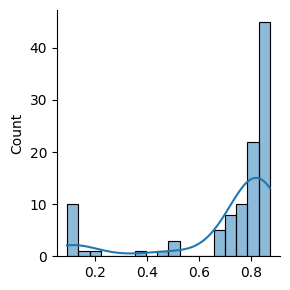

In [10]:
import seaborn as sns
sns.displot(preds_proba, kde=True, height=3)

### With Imputation

In [11]:
from sklearn.impute import SimpleImputer

In [12]:
train = pd.read_csv("../data/splits/incomplete_df/train.csv")
test = pd.read_csv("../data/splits/incomplete_df/test.csv")

In [13]:
for feat in CATS:
    train[feat] = pd.Categorical(train[feat].astype(str))
    test[feat] = pd.Categorical(test[feat].astype(str))

In [32]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, CONTS),
        ('cat', categorical_transformer, CATS)])

In [33]:
model = Pipeline(steps=[('preprocessor', preprocessor),
                   ('clf', RandomForestClassifier(random_state=42, n_estimators=25))])  

In [34]:
model.fit(train[CONTS + CATS], train[TARGET])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['feature_5', 'feature_6',
                                                   'feature_7']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['feature_0', 'feature_1',
                                                   'feature_2', 'feature_3',
                                                   'feature_4', 'feature_10',
                                                   'feature_11', 'feature_12',
                                                   'feature_8',
                                                   'feature_9'])])),
                ('clf',
                 RandomForestClassifier(n_estimators=25, random_state=42))])

In [35]:
from sklearn import metrics
preds = model.predict(test[CONTS + CATS])
preds_proba = model.predict_proba(test[CONTS + CATS])[:,1]
print(metrics.classification_report(test[TARGET], preds))
print("Confusion:\n", metrics.confusion_matrix(test[TARGET], preds), "\n")
print("ROC-AUC: ", metrics.roc_auc_score(test[TARGET], preds_proba))
print("Log loss: ", metrics.log_loss(test[TARGET], preds_proba))
print("Brier: ", metrics.brier_score_loss(test[TARGET], preds_proba))

              precision    recall  f1-score   support

           0       0.58      0.40      0.47        45
           1       0.76      0.87      0.81       100

    accuracy                           0.72       145
   macro avg       0.67      0.64      0.64       145
weighted avg       0.71      0.72      0.71       145

Confusion:
 [[18 27]
 [13 87]] 

ROC-AUC:  0.6845555555555555
Log loss:  0.8275069903732186
Brier:  0.20017806558761436


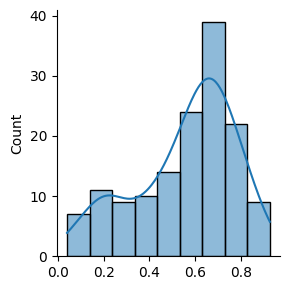

In [18]:
import seaborn as sns
sns.displot(preds_proba, kde=True, height=3)

### Hyperparameter Tuning and Model Selection

In [19]:
from skopt import BayesSearchCV

In [37]:
model = Pipeline(steps=[('preprocessor', preprocessor),
                   ('clf', RandomForestClassifier(random_state=42))])  

In [38]:
from sklearn.metrics import make_scorer

In [39]:
parameters = {
    "clf__n_estimators": [25, 50, 100]
}

bayes = BayesSearchCV(model,
                      search_spaces=parameters,
                      scoring=make_scorer(metrics.f1_score, pos_label=0),
                      n_iter=20, cv=4)

In [43]:
bayes.best_estimator_.named_steps.clf.__class__.__name__

'RandomForestClassifier'

In [40]:
bayes.fit(train[CONTS + CATS], train[TARGET])

/Users/nerdai/Library/Caches/pypoetry/virtualenvs/ivado-assignment-flevcKW5-py3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/nerdai/Library/Caches/pypoetry/virtualenvs/ivado-assignment-flevcKW5-py3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/nerdai/Library/Caches/pypoetry/virtualenvs/ivado-assignment-flevcKW5-py3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/nerdai/Library/Caches/pypoetry/virtualenvs/ivado-assignment-flevcKW5-py3.11/lib/python3.11/site-packages/

BayesSearchCV(cv=4,
              estimator=Pipeline(steps=[('preprocessor',
                                         ColumnTransformer(transformers=[('num',
                                                                          Pipeline(steps=[('imputer',
                                                                                           SimpleImputer(strategy='median'))]),
                                                                          ['feature_5',
                                                                           'feature_6',
                                                                           'feature_7']),
                                                                         ('cat',
                                                                          Pipeline(steps=[('imputer',
                                                                                           SimpleImputer(fill_value='missing',
                                                                                                         strategy='constant')),
                                                                                          ('onehot',
                                                                                           OneHotEncoder(drop='first',
                                                                                                         handle_unknown='ignore'))]),
                                                                          ['feature_0',
                                                                           'feature_1',
                                                                           'feature_2',
                                                                           'feature_3',
                                                                           'feature_4',
                                                                           'feature_10',
                                                                           'feature_11',
                                                                           'feature_12',
                                                                           'feature_8',
                                                                           'feature_9'])])),
                                        ('clf',
                                         RandomForestClassifier(random_state=42))]),
              n_iter=20, scoring=make_scorer(f1_score, pos_label=0),
              search_spaces={'clf__n_estimators': [25, 50, 100]})

In [41]:
bayes.best_score_

0.5965408805031446

In [25]:
train.shape

(433, 17)

In [29]:
categorical_transformer.fit_transform(train[[CATS[0]]])

<433x2 sparse matrix of type '<class 'numpy.float64'>'
	with 351 stored elements in Compressed Sparse Row format>

In [27]:
from sklearn import metrics
preds = bayes.predict(test[CONTS + CATS])
preds_proba = bayes.predict_proba(test[CONTS + CATS])[:,1]
print(metrics.classification_report(test[TARGET], preds))
print("Confusion:\n", metrics.confusion_matrix(test[TARGET], preds), "\n")
print("ROC-AUC: ", metrics.roc_auc_score(test[TARGET], preds_proba))
print("Log loss: ", metrics.log_loss(test[TARGET], preds_proba))
print("Brier: ", metrics.brier_score_loss(test[TARGET], preds_proba))

              precision    recall  f1-score   support

           0       0.45      0.44      0.45        45
           1       0.75      0.76      0.76       100

    accuracy                           0.66       145
   macro avg       0.60      0.60      0.60       145
weighted avg       0.66      0.66      0.66       145

Confusion:
 [[20 25]
 [24 76]] 

ROC-AUC:  0.6635555555555556
Log loss:  0.624745301648208
Brier:  0.21612589949175073


In [45]:
bayes.cv_results_

{'mean_fit_time': array([0.02421844, 0.01941669, 0.03468609, 0.06328678, 0.03464508,
        0.06665033, 0.02051991, 0.03399789, 0.03443325, 0.08894807,
        0.02993608, 0.04934084, 0.04313791, 0.04549068, 0.05207199,
        0.04738754, 0.04982156, 0.02793992, 0.02134377, 0.0601927 ]),
 'std_fit_time': array([0.004141  , 0.00011272, 0.0003332 , 0.00051747, 0.00080278,
        0.00144356, 0.00052557, 0.00017804, 0.00024036, 0.03735808,
        0.00699575, 0.00787138, 0.0186163 , 0.0146008 , 0.02837078,
        0.0188888 , 0.01137419, 0.00745839, 0.00089568, 0.02872764]),
 'mean_score_time': array([0.00410265, 0.00334024, 0.00422758, 0.00561738, 0.00431645,
        0.00633299, 0.0039072 , 0.00404716, 0.00418603, 0.01212418,
        0.01108736, 0.00756216, 0.0048123 , 0.01719081, 0.0058431 ,
        0.00744194, 0.00643653, 0.00893408, 0.00527602, 0.00783426]),
 'std_score_time': array([7.78186544e-04, 6.42078984e-05, 2.08605315e-04, 2.14798336e-04,
        1.95788293e-04, 4.08878080e-

In [28]:
bayes.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['feature_5', 'feature_6',
                                                   'feature_7']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['feature_0', 'feature_1',
                                                   'feature_2', 'feature_3',
                                                   'feature_4', 'feature_10',
                                                   'feature_11', 'feature_12',
                                                   'feature_8',
                                                   'feature_9'])])),
                ('clf', BalancedRandomForestClassifier(random_state=42))])